In [1]:
import tensorflow as tf

# model 
import src.models.efficientdet as efficientdet
import src.config as config

In [2]:
configs = config.Configs(
    training_type="obd",
    dataset_path="datasets/data/obd_fundus",
    training_dir="training_dir-ipynb"
)

## Test the dataset pipeline

In [3]:
import src.dataset as dataset

# Grab the file names
labeled_file_names = dataset.load_data(
    configs=configs,
    dataset_type="labeled"
)
unlabeled_file_names = dataset.load_data(
    configs=configs,
    dataset_type="unlabeled"
)

print("Labeled file names: {}".format(labeled_file_names[0:5]))
print("Unlabeled file names: {}".format(unlabeled_file_names[0:5]))


Labeled file names: ['mic_0005', 'ldm_0050', 'ldm_0061', 'ldm_0080', 'dru_0003']
Unlabeled file names: ['20051116_54825_0400_PP', 'image057', 'image053', '20051116_43801_0400_PP', '20051130_54956_0400_PP']


In [4]:
# Update configs with the new dataset information
configs.update_training_configs(
    dataset_size=len(labeled_file_names),
    unlabeled_data_size=len(unlabeled_file_names)
)

In [5]:
# define and create the datasets
lb_dataset = dataset.Dataset(
    file_names=labeled_file_names,
    configs=configs,
    dataset_type="labeled"
).create_dataset()
ulb_dataset = dataset.Dataset(
    file_names=unlabeled_file_names,
    configs=configs,
    dataset_type="unlabeled"
).create_dataset()

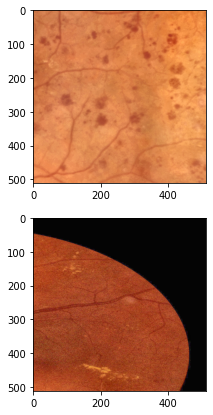

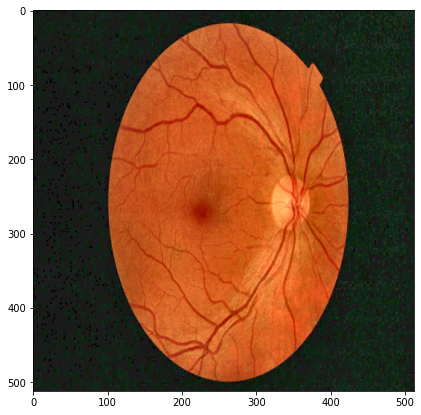

In [6]:
# plot a sample of the images
import matplotlib.pyplot as plt

for i, (x, y) in enumerate(lb_dataset):
    fig = plt.figure(figsize=(10, 7))
    for i, (batched_x) in enumerate(x):
        fig.add_subplot(x.numpy().shape[0], 1, i+1)
        plt.imshow(batched_x.numpy())
    plt.show()
    break
for i, (x, y) in enumerate(ulb_dataset):
    fig = plt.figure(figsize=(10, 7))
    for i, (batched_x) in enumerate(x):
        fig.add_subplot(x.numpy().shape[0], 1, i+1)
        plt.imshow(batched_x.numpy())
    plt.show()
    break


## Training pipeline

In [7]:
# Build the model
import src.utils.training_utils as training_utils
import src.models.efficientdet as efficientdet

teacher_model = efficientdet.model_builder(
    configs=configs,
    name="teacher"
)
tutor_model = efficientdet.model_builder(
    configs, 
    name="tutor"
)
ema_model = efficientdet.model_builder(
    configs, 
    name="ema"
)

teacher_model.summary()
tutor_model.summary()
ema_model.summary()

Model: "EfficientDet-D0 teacher"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficient_net (EfficientNet)   [(None, 64, 64, 40)  6771296     ['input_1[0][0]']                
                                , (None, 32, 32, 80                                               
                                ),                                                                
                                 (None, 16, 16, 112                                               
                                ),                                          

In [8]:
# Optimizers and losses
teacher_optimizer = tf.keras.optimizers.Adam(
    learning_rate = configs.teacher_learning_rate)
tutor_optimizer = tf.keras.optimizers.Adam(
    learning_rate = configs.tutor_learning_rate)
student_optimizer = tf.keras.optimizers.Adam()

import src.losses.effdet_loss as effdet_loss
from tensorflow.keras.losses import KLDivergence
focal_loss_func = effdet_loss.FocalLoss(
    configs=configs
)
regression_func = effdet_loss.RegressionLoss(
    configs=configs
)

In [42]:
from src.losses.iou import IOU
from src.losses.anchor import Anchors
from src.losses.effdet_loss import *
import numpy as np

class FocalLoss:
    def __init__(self, configs):
        self.configs = configs
        self.alpha = configs.alpha
        self.gamma = configs.gamma
        self.anchors = Anchors(
            scales = configs.scales, 
            ratios = configs.ratios,
            configs = configs)(image_size = self.configs.image_dims)

    def __call__(self, cls_results, reg_results, labels):
        assert cls_results.shape[0] == reg_results.shape[0]
        batch_size = cls_results.shape[0]
        cls_loss_list = []
        reg_loss_list = []


        cls_results = tf.stop_gradient(cls_results).numpy()
        reg_results = tf.stop_gradient(reg_results).numpy()
        labels = labels.numpy()
        anchor = self.anchors[0, :, :]

        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_center_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_center_y = anchor[:, 1] + 0.5 * anchor_heights

        for n in range(batch_size):
            class_result = cls_results[n, :, :]
            reg_result = reg_results[n, :, :]

            # print("class result", np.array(class_result).shape)
            # print("reg result", np.array(reg_result).shape)

            box_annotation = labels[n, :, :]
            # Filter out the extra padding boxes.
            box_annotation = box_annotation[box_annotation[:, 4] != -1]

            if box_annotation.shape[0] == 0:
                cls_loss_list.append(tf.constant(0, dtype=tf.dtypes.float32))
                reg_loss_list.append(tf.constant(0, dtype=tf.dtypes.float32))
                continue

            class_result = tf.clip_by_value(t=class_result, clip_value_min=1e-4, clip_value_max=1.0 - 1e-4)

            iou_value = IOU(box_1=anchor, box_2=box_annotation[:, :4]).calculate_iou()
            # print("iou_value", iou_value)
            iou_max = tf.math.reduce_max(iou_value, axis=1)
            iou_argmax = tf.math.argmax(iou_value, axis=1)
            # print("iou argmax", iou_argmax)
            
            targets = tf.ones_like(class_result) * -1
            targets = item_assignment(input_tensor=targets,
                                      boolean_mask=tf.math.less(iou_max, 0.4),
                                      value=0,
                                      axes=[1])
            # print("box annotation", box_annotation)
            positive_indices = tf.math.greater(iou_max, 0.5)
            num_positive_anchors = tf.reduce_sum(tf.dtypes.cast(x=positive_indices, dtype=tf.int32))
            
            assigned_annotations = box_annotation[iou_argmax, :]

            targets = item_assignment(input_tensor=targets,
                                      boolean_mask=positive_indices,
                                      value=0,
                                      axes=[1])

            targets = advanced_item_assignmnet(input_tensor=targets,
                                               boolean_mask=positive_indices,
                                               value=1,
                                               target_elements=tf.convert_to_tensor(assigned_annotations[:, 4], dtype=tf.float32),
                                               elements_axis=1)

            alpha_factor = tf.ones_like(targets) * self.alpha
            alpha_factor = tf.where(tf.math.equal(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = tf.where(tf.math.equal(targets, 1.), 1. - class_result, class_result)
            focal_weight = alpha_factor * tf.math.pow(focal_weight, self.gamma)
            bce = -(targets * tf.math.log(class_result) + (1.0 - targets) * tf.math.log(1.0 - class_result))

            cls_loss = focal_weight * bce
            cls_loss = tf.where(tf.math.not_equal(targets, -1.0), cls_loss, tf.zeros_like(cls_loss))
            cls_loss_list.append(tf.math.reduce_sum(cls_loss) / tf.keras.backend.clip(x=tf.cast(num_positive_anchors, dtype=tf.float32), min_value=1.0, max_value=None))

            if num_positive_anchors > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_center_x_pi = anchor_center_x[positive_indices]
                anchor_center_y_pi = anchor_center_y[positive_indices]
                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_center_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_center_y = assigned_annotations[:, 1] + 0.5 * gt_heights
                gt_widths = tf.keras.backend.clip(x=gt_widths, min_value=1, max_value=None)
                gt_heights = tf.keras.backend.clip(x=gt_heights, min_value=1, max_value=None)

                targets_dx = (gt_center_x - anchor_center_x_pi) / anchor_widths_pi
                targets_dy = (gt_center_y - anchor_center_y_pi) / anchor_heights_pi
                targets_dw = tf.math.log(gt_widths / anchor_widths_pi)
                targets_dh = tf.math.log(gt_heights / anchor_heights_pi)
                targets = tf.stack([targets_dx, targets_dy, targets_dw, targets_dh])
                targets = tf.transpose(a=targets, perm=[1, 0])
                targets = targets / tf.constant([[0.1, 0.1, 0.2, 0.2]])

                reg_diff = tf.math.abs(targets - tf.boolean_mask(reg_result, positive_indices, axis=0))
                reg_loss = tf.where(tf.math.less_equal(reg_diff, 1.0 / 9.0), 0.5 * 9.0 * tf.math.pow(reg_diff, 2), reg_diff - 0.5 / 9.0)
                reg_loss_list.append(tf.reduce_mean(reg_loss))
            else:
                reg_loss_list.append(tf.constant(0, dtype=tf.float32))

        final_cls_loss = tf.math.reduce_mean(tf.stack(cls_loss_list, axis=0), axis=0, keepdims=True)
        final_reg_loss = tf.math.reduce_mean(tf.stack(reg_loss_list, axis=0), axis=0, keepdims=True)

        print("cls", final_cls_loss)
        print("reg", final_reg_loss)

        loss = tf.math.reduce_sum([final_cls_loss, final_reg_loss])

        print(loss)
        return loss

In [44]:
# create the uda loss function
class UDA:
    """UDA Loss Function."""
    def __init__(self, configs):
        self.training_type = configs.training_type
        self.configs = configs

        if self.training_type == "obd":
            """
            self.cls_loss = effdet_loss.FocalLoss(
                configs = configs)
            self.box_loss = effdet_loss.RegressionLoss(
                configs = configs)
            """
            self.loss = FocalLoss(configs)
            self.consistency_loss = KLDivergence()

    def __call__(self, y_true, y_pred):
        if self.training_type == "obd":
            labels = {"l": y_true}
            masks = {}
            logits = {}
            loss = {}
            
            # Splits the predictions for labeled, and unlabeled
            logits["l"], logits["u_ori"], logits["u_aug"] = tf.split(
                y_pred,
                [self.configs.batch_size,
                 self.configs.unlabeled_batch_size,
                 self.configs.unlabeled_batch_size],
                axis = 0)

            # Step 1: Loss for Labeled Values

            reg_results, cls_results = logits["l"][..., :4], logits["l"][..., 4:]
            loss["l"] = self.loss(cls_results, reg_results, labels["l"])
            # print(loss["l"])
            loss["l"] = tf.reduce_sum(loss["l"] / float(self.configs.batch_size))

            # Step 2: Loss for unlabeled values
            labels["u_ori"] = logits["u_ori"]
            loss["u"] = self.consistency_loss(labels["u_ori"], logits["u_aug"])
            """
            labels["u_ori"] = tf.nn.sigmoid(
                logits["u_ori"] / tf.convert_to_tensor(self.configs.uda_label_temperature))
            labels["u_ori"] = tf.stop_gradient(labels["u_ori"])

            loss["u"] = tf.math.reduce_mean(self.cls_loss(labels["u_ori"], logits["u_aug"])) + \
                        tf.math.reduce_mean(self.box_loss(labels["u_ori"], logits["u_aug"]))

            largest_probs = tf.reduce_max(
                labels["u_ori"], axis = -1, keepdims = True)
            masks["u"] = tf.math.greater_equal(
                largest_probs, 
                tf.constant(self.configs.uda_threshold))
            masks["u"] = tf.cast(masks["u"], tf.float32)
            masks["u"] = tf.stop_gradient(masks["u"])
            loss["u"] = tf.reduce_sum(-loss["u"] * masks["u"]) / \
                        tf.convert_to_tensor(
                            self.configs.unlabeled_batch_size, 
                            dtype = tf.float32)
            """
            return logits, labels, masks, loss

In [47]:
EPOCHS = 10
STEPS = configs.total_steps

print("Training beginning")

uda_func = UDA(configs = configs)
for epoch in EPOCHS:
    print("epoch {}".format(epoch))
    for i, (org, aug) in enumerate(ulb_dataset):
        lb_image, lb_label = next(iter(lb_dataset))
        with tf.GradientTape() as tape:
            all_images = tf.concat([lb_image, org, aug], axis=0)
            all_logits = teacher_model(all_images, training=True)
            logits, labels, masks, loss = uda_func(lb_label, all_logits)
            total_loss = loss["l"] + loss["u"]
        gradients = tape.gradient(
            loss, teacher_model.trainable_variables
        )
        teacher_optimizer.apply_gradients(
            zip(gradients, teacher_model.trainable_variables)
        )
        print("step: {}, loss: {}".format(i, loss))


Training beginning
class result (49104, 8)
reg result (49104, 4)
iou_value [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.        ]
 [0.01024209]
 [0.01818593]]
iou argmax tf.Tensor([0 0 0 ... 0 0 0], shape=(49104,), dtype=int64)
box annotation [[ 70.  64. 254. 195.   1.]]
class result (49104, 8)
reg result (49104, 4)
iou_value [[0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00]
 ...
 [3.3888675e-05 0.0000000e+00]
 [6.4848579e-02 0.0000000e+00]
 [1.0500732e-01 0.0000000e+00]]
iou argmax tf.Tensor([0 0 0 ... 0 0 0], shape=(49104,), dtype=int64)
box annotation [[ 286.  810.  639. 1177.    5.]
 [1152.  886. 1650. 1275.    6.]]
cls tf.Tensor([1399824.1], shape=(1,), dtype=float32)
reg tf.Tensor([17.01156], shape=(1,), dtype=float32)
tf.Tensor(1399841.1, shape=(), dtype=float32)
tf.Tensor(1399841.1, shape=(), dtype=float32)
step: 0, loss: {'l': <tf.Tensor: shape=(), dtype=float32, numpy=699920.56>, 'u': <tf.Tensor: shape=(), dtype=float32, numpy=